In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
def prepare_data(data_path: str, city_name: str, x_len: int, y_len: int, train_size: float) -> list:
    """Preprocess data and return train and test sequences.

    Args:
        data_path (str): Path to data file.
        city_name (str): Name of city for which data will be extracted.
        x_len (int): Length of single X sequence.
        y_len (int): Length of single y sequence.
        train_size (float): Specifies proportion of train data to all data.

    Returns:
       (list): List containing train-test split of data.
    """

    # Read data
    df: pd.DataFrame = pd.read_csv(data_path, usecols=['datetime', city_name]).dropna()

    # Calculate mean value for each day
    df['date'] = pd.to_datetime(df['datetime'])
    data: np.ndarray = df.groupby(df['date'].dt.date)[city_name].mean().to_numpy()

    # Prepare X and y sequences
    num_sequences: int = data.size + 1 - x_len - y_len
    X = np.zeros((num_sequences, x_len), dtype=np.float32)
    y = np.zeros((num_sequences, y_len), dtype=np.float32)
    for i in range(num_sequences):
        X[i] = data[i:(i+x_len)]
        y[i] = data[i+x_len:(i+x_len+y_len)]

    # Return train and test sequences
    train_len = int(num_sequences * train_size)
    return [X[:train_len], X[train_len:], y[:train_len], y[train_len:]]

In [12]:
def draw_training_process(history, key1='mse') -> None:
    """Draws a plot of training process.

    Args:
      history (keras.callbacks.History): object that contains information about the training process.
      key1 (str): Specifies the key in 'history.history' to plot on the y-axis, for example "mse".

    Returns:
      None
    """
    plt.figure(figsize=(12,6))
    plt.plot(np.log(history.history[key1]), "r--")
    plt.plot(np.log(history.history['val_' + key1]), "g--")
    plt.ylabel(key1)
    plt.xlabel('Epoch')
    plt.title(f"Training process")
    plt.legend(['train', 'test'], loc='best')
 
    plt.show()

def metrics_and_plots(history,y_true,y_pred,y_len, temp=True) -> None:
  """Draws plots of weather predictions and calculates evaluation metrics.

  Args:
    history (keras.callbacks.History): object that contains information about the training process.
    y_true (np.array): A numpy array of shape (n_samples, n_features) that contains true values of weather variables.
    y_pred (np.array): A numpy array of shape (n_samples, n_features) that contains predicted values of weather variables.
    y_len (int): Specifies the number of days to plot and calculate metrics for, at our place 4.

  Returns:
    None
  """
  #draws a plot of training process
  draw_training_process(history,key1='mse')

  #draws plots of weather predictions
  print("Weather predictions")
  fig, axes = plt.subplots(y_len, 1, figsize=(8, 24), sharex=False)
  l = 'Temperature (K)' if temp else 'Wind speed'
  for i in range(y_len):
    axes[i].plot(y_true[:, i], label='True values')
    axes[i].plot(y_pred[:, i], label='Predicted values')
    axes[i].set_xlabel("Day in year")
    axes[i].set_ylabel(l)
    axes[i].legend()
    axes[i].set_title(f"Day {i+1}")
  plt.show()

  #calculate metrics 
  print("Metrics for 4 consecutive days")
  for i in range(y_len):
    y_test = y_true[:, i]
    y_pred_day = y_pred[:,i]
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_day))
    mse = mean_squared_error(y_test, y_pred_day)
    mae = mean_absolute_error(y_test, y_pred_day)
    r2 = r2_score(y_test, y_pred_day)
    pearson, _ = pearsonr(y_test, y_pred_day)
    ia = (1 -(np.sum((y_pred_day-y_test)**2))/(np.sum((np.abs(y_test-np.mean(y_pred_day))+np.abs(y_pred_day-np.mean(y_pred_day)))**2)))
    print(f"Day {i+1}: RMSE={rmse:.4f}, MSE={mse:.4f}, MAE={mae:.4f}, R^2={r2:.4f}, Pearson={pearson:.4f}, IA={ia:.4f}")

In [4]:
data_path = '/content/drive/MyDrive/SSN/data/temperature.csv'
x_len = 7
y_len = 4
train_size = 0.8
X_tV_train, X_tV_test, y_tV_train, y_tV_test = prepare_data(data_path, 'Vancouver', x_len, y_len, train_size)
X_tLA_train, X_tLA_test, y_tLA_train, y_tLA_test = prepare_data(data_path, 'Los Angeles', x_len, y_len, train_size)

In [6]:
data_path = '/content/drive/MyDrive/SSN/data/wind_speed.csv'
x_len = 7
y_len = 4
train_size = 0.8
X_wV_train, X_wV_test, y_wV_train, y_wV_test = prepare_data(data_path, 'Vancouver', x_len, y_len, train_size)
X_wLA_train, X_wLA_test, y_wLA_train, y_wLA_test = prepare_data(data_path, 'Los Angeles', x_len, y_len, train_size)

# Create conv1d model

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, LeakyReLU
from keras import Input

def prepare_model():
  model = Sequential()
  model.add(Input(shape=(x_len,1)))

  model.add(Conv1D(64, 4, activation='relu', dilation_rate=2))
  model.add(Flatten())
  model.add(Dense(64))
  model.add(Dense(32))
  model.add(Dense(y_len))

  model.compile(optimizer='adam', loss='mse', metrics=['mse'])
  model.summary()
  return model

## Temperature - Vancouver

In [ ]:
from keras.callbacks import EarlyStopping
model_tV = prepare_model() 
EarlyStop = EarlyStopping(monitor='loss', 
                          patience=10,
                          verbose=1)
history_tV = model_tV.fit(X_tV_train, y_tV_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[EarlyStop])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 1, 64)             320       
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 4)                 132       
                                                                 
Total params: 6,692
Trainable params: 6,692
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
37/37 [==============================] - 

12/12 [==============================] - 0s 2ms/step


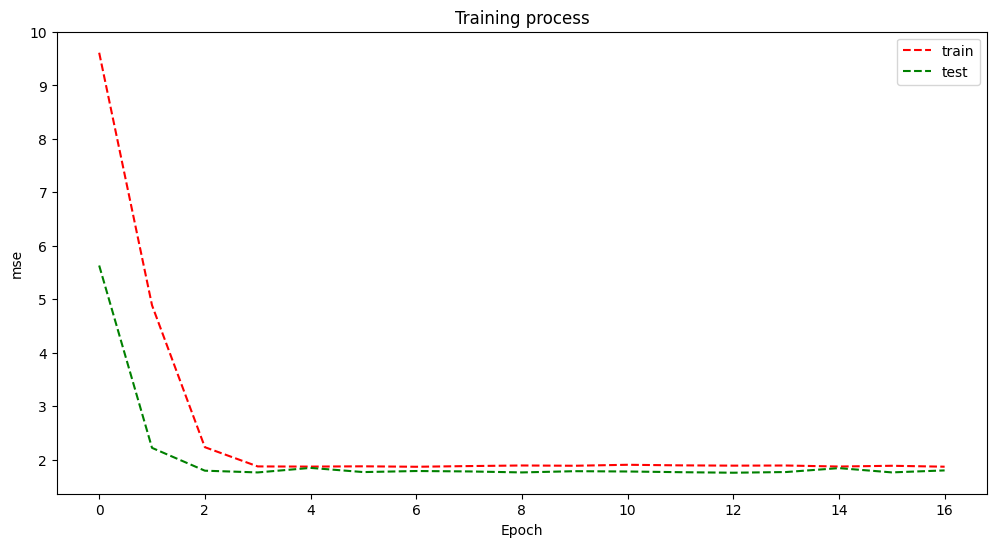

Weather predictions


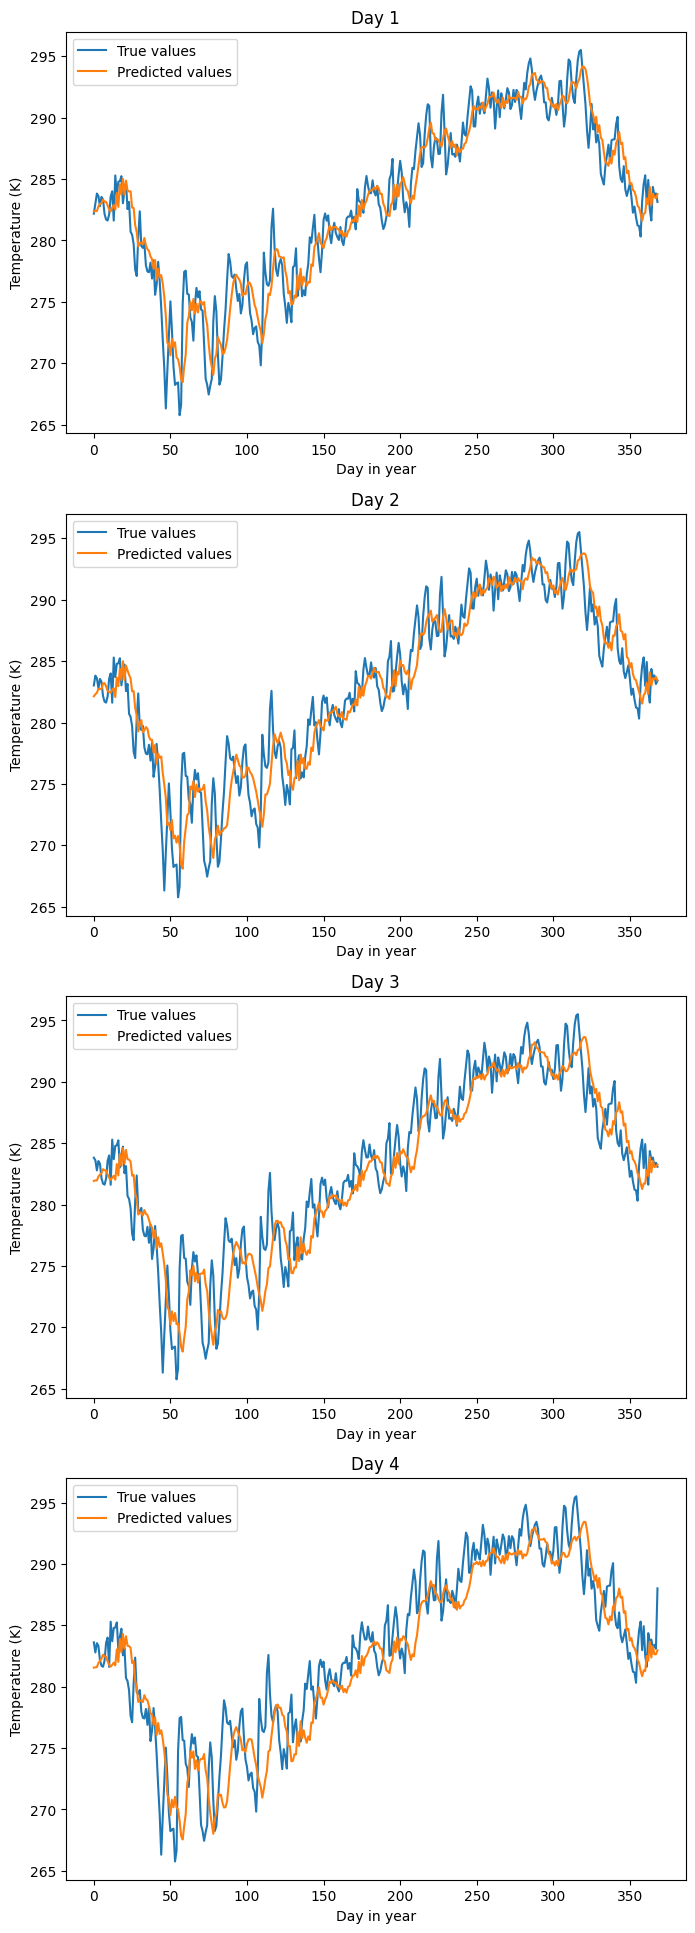

Metrics for 4 consecutive days
Day 1: RMSE=2.0924, MSE=4.3783, MAE=1.6211, R^2=0.9066, Pearson=0.9524, IA=0.9754
Day 2: RMSE=2.4007, MSE=5.7633, MAE=1.8527, R^2=0.8770, Pearson=0.9371, IA=0.9673
Day 3: RMSE=2.6791, MSE=7.1773, MAE=2.0293, R^2=0.8468, Pearson=0.9229, IA=0.9591
Day 4: RMSE=2.8904, MSE=8.3547, MAE=2.2161, R^2=0.8220, Pearson=0.9142, IA=0.9524


In [ ]:
y_tV_pred = model_tV.predict(X_tV_test)
metrics_and_plots(history_tV,y_tV_test,y_tV_pred,y_len)

## Temperature - Los Angeles

In [ ]:
model_tLA = prepare_model() 
EarlyStop = EarlyStopping(monitor='loss', 
                          patience=10,
                          verbose=1)
history_tLA = model_tLA.fit(X_tLA_train, y_tLA_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[EarlyStop])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 1, 64)             320       
                                                                 
 flatten_8 (Flatten)         (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 4)                 132       
                                                                 
Total params: 6,692
Trainable params: 6,692
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
38/38 [==============================] - 

12/12 [==============================] - 0s 3ms/step


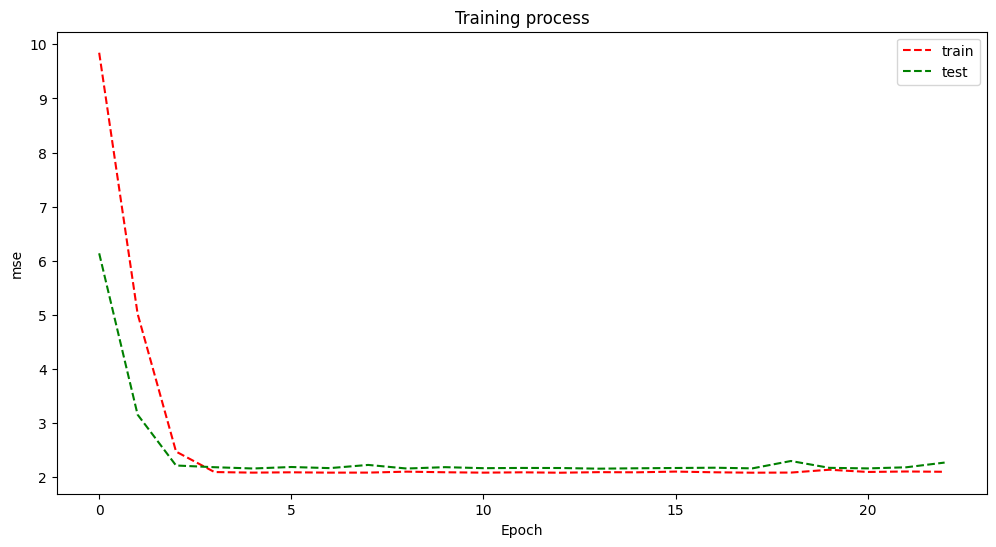

Weather predictions


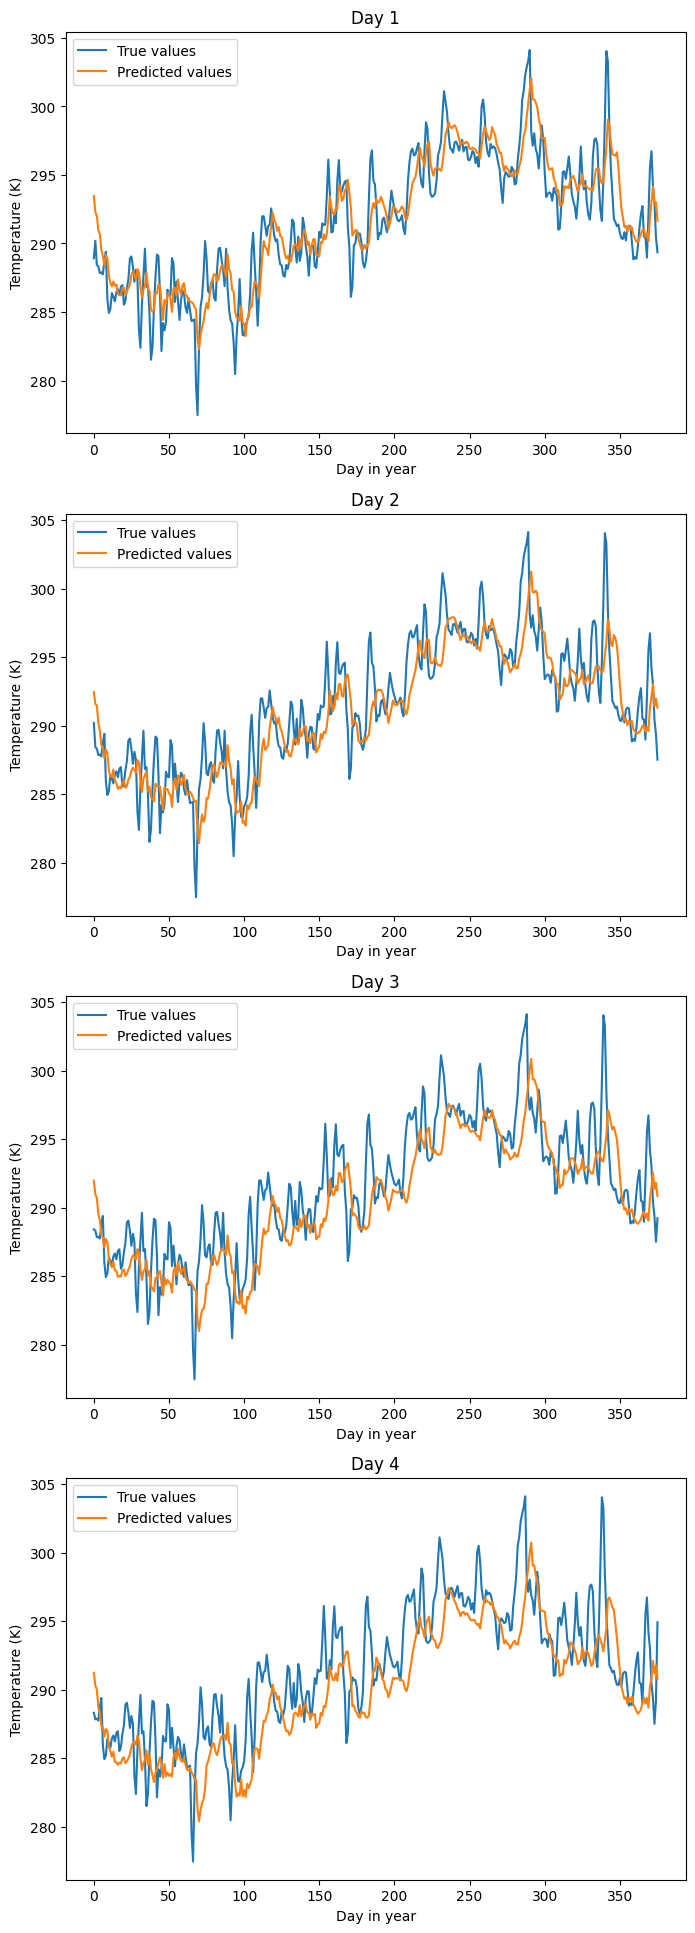

Metrics for 4 consecutive days
Day 1: RMSE=2.0344, MSE=4.1387, MAE=1.5948, R^2=0.8099, Pearson=0.9017, IA=0.9462
Day 2: RMSE=2.5241, MSE=6.3710, MAE=1.9082, R^2=0.7076, Pearson=0.8530, IA=0.9157
Day 3: RMSE=2.9209, MSE=8.5315, MAE=2.2144, R^2=0.6087, Pearson=0.8191, IA=0.8872
Day 4: RMSE=3.2572, MSE=10.6091, MAE=2.4835, R^2=0.5135, Pearson=0.7971, IA=0.8617


In [ ]:
y_tLA_pred = model_tLA.predict(X_tLA_test)
metrics_and_plots(history_tLA,y_tLA_test,y_tLA_pred,y_len)

## Temperature - Vancouver model predicts LA temperatures

12/12 [==============================] - 0s 2ms/step


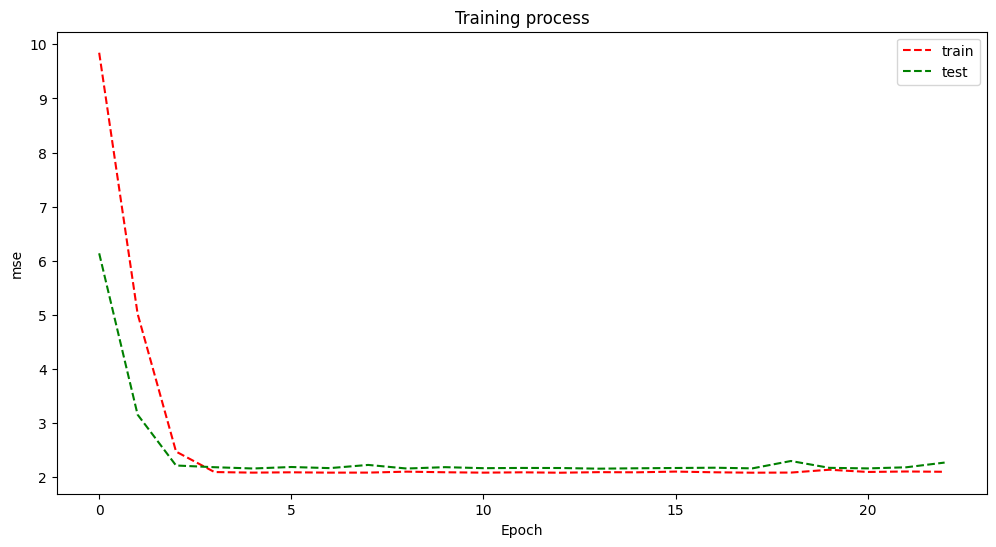

Weather predictions


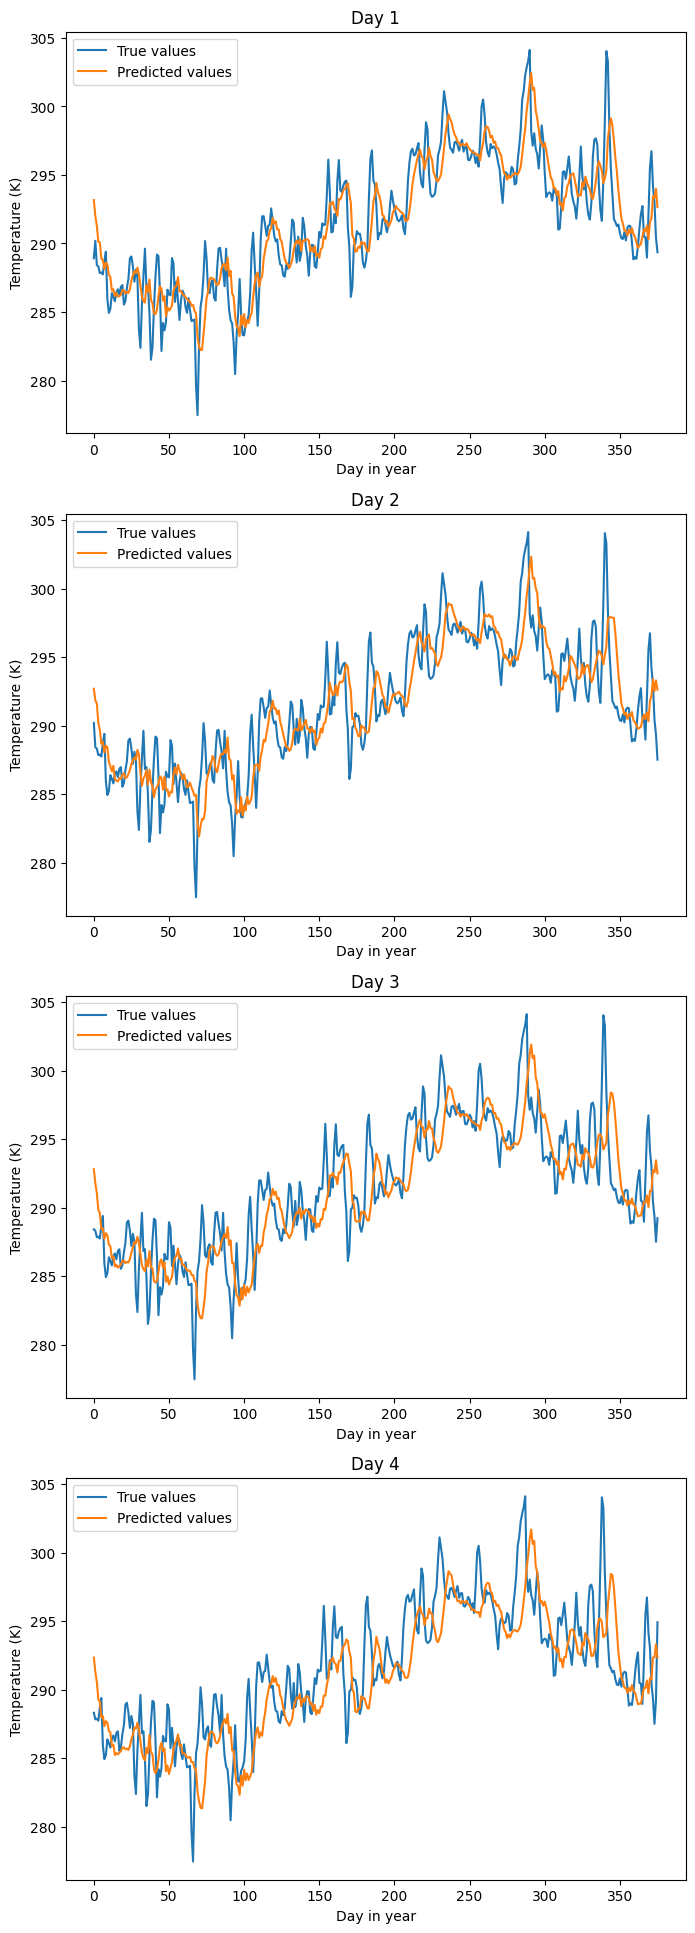

Metrics for 4 consecutive days
Day 1: RMSE=2.1962, MSE=4.8232, MAE=1.6787, R^2=0.7784, Pearson=0.8837, IA=0.9373
Day 2: RMSE=2.5221, MSE=6.3610, MAE=1.9362, R^2=0.7081, Pearson=0.8454, IA=0.9158
Day 3: RMSE=2.8406, MSE=8.0690, MAE=2.1811, R^2=0.6299, Pearson=0.8062, IA=0.8920
Day 4: RMSE=3.0158, MSE=9.0948, MAE=2.3001, R^2=0.5829, Pearson=0.7910, IA=0.8786


In [ ]:
y_tVLA_pred = model_tV.predict(X_tLA_test)
metrics_and_plots(history_tLA,y_tLA_test,y_tVLA_pred,y_len)

## Temperature - LA model predicts Vancouver temp

12/12 [==============================] - 0s 3ms/step


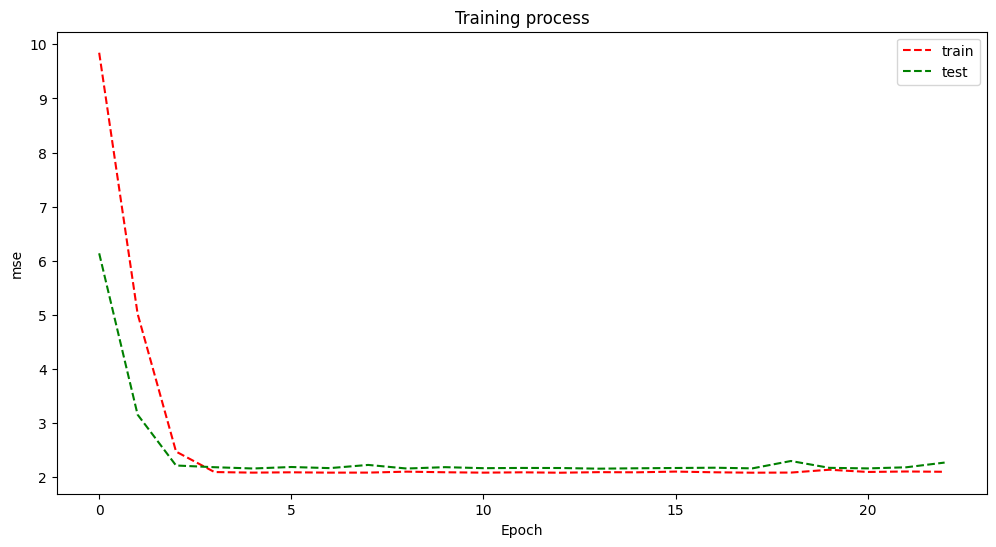

Weather predictions


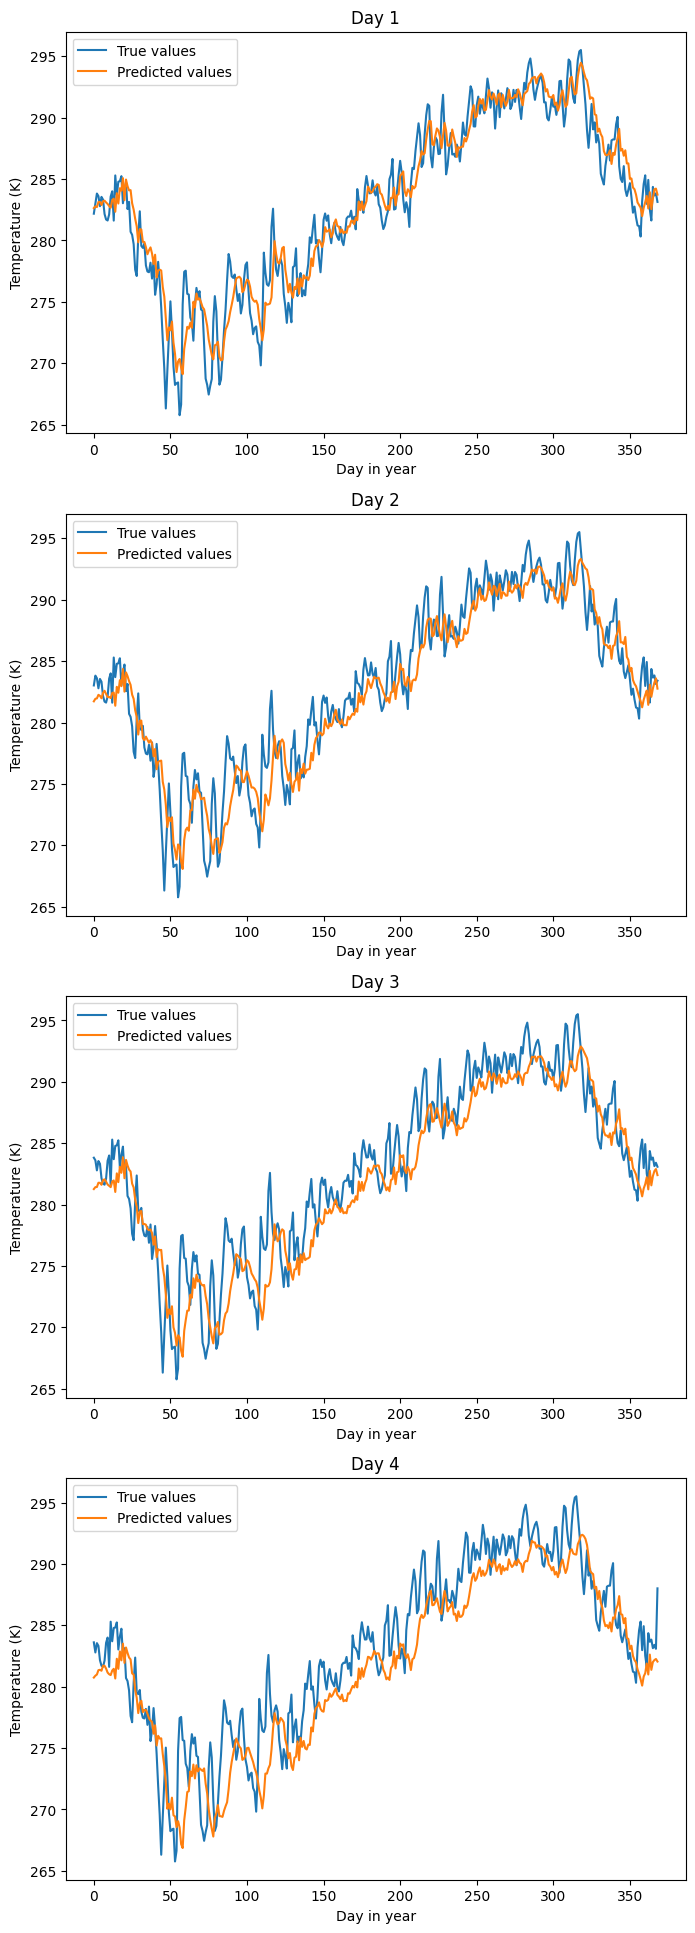

Metrics for 4 consecutive days
Day 1: RMSE=1.9927, MSE=3.9708, MAE=1.5562, R^2=0.9153, Pearson=0.9574, IA=0.9777
Day 2: RMSE=2.4504, MSE=6.0043, MAE=1.8838, R^2=0.8719, Pearson=0.9380, IA=0.9659
Day 3: RMSE=2.7943, MSE=7.8082, MAE=2.1628, R^2=0.8334, Pearson=0.9266, IA=0.9556
Day 4: RMSE=3.1275, MSE=9.7815, MAE=2.4629, R^2=0.7916, Pearson=0.9172, IA=0.9446


In [ ]:
y_tLAV_pred = model_tLA.predict(X_tV_test)
metrics_and_plots(history_tLA,y_tV_test,y_tLAV_pred,y_len)

# Wind speed predictions

## Wind - Vancouver

In [8]:
model_wV = prepare_model() 
EarlyStop = EarlyStopping(monitor='loss', 
                          patience=10,
                          verbose=1)
history_wV = model_wV.fit(X_wV_train, y_wV_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[EarlyStop])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             320       
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 6,692
Trainable params: 6,692
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
37/37 [==============================] - 

12/12 [==============================] - 0s 2ms/step


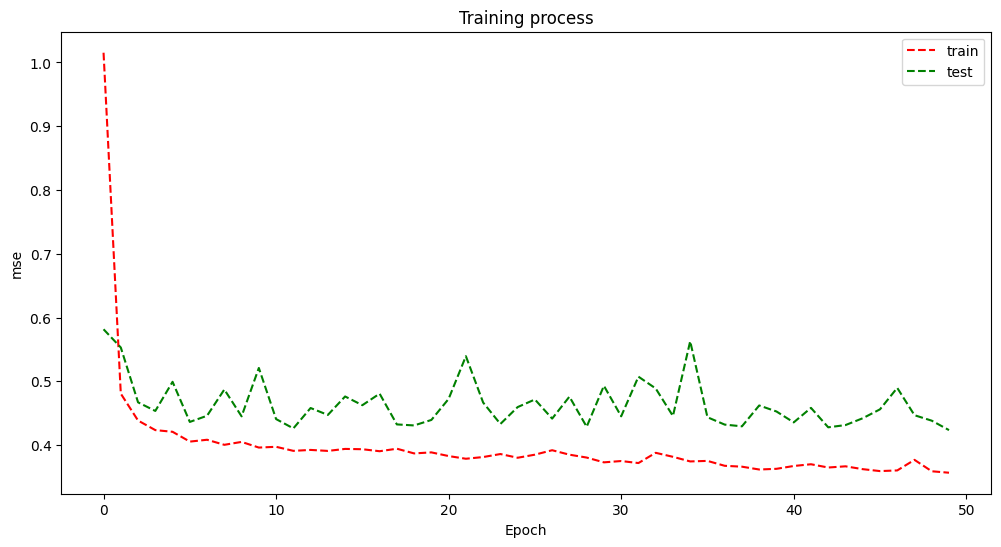

Weather predictions


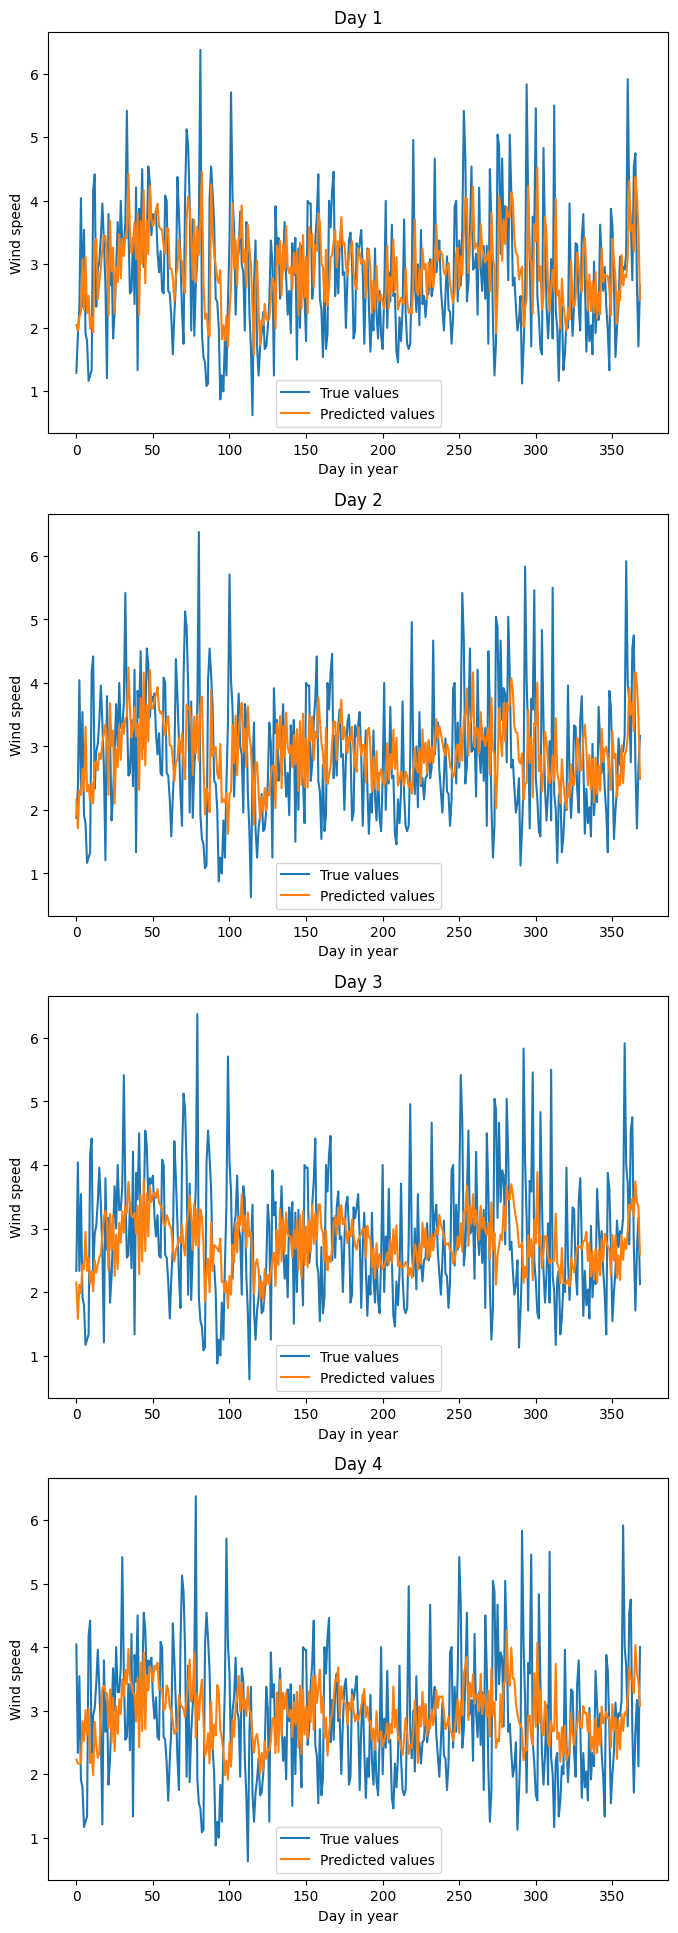

Metrics for 4 consecutive days
Day 1: RMSE=0.9855, MSE=0.9713, MAE=0.7785, R^2=0.0320, Pearson=0.3239, IA=0.5477
Day 2: RMSE=1.0602, MSE=1.1240, MAE=0.8470, R^2=-0.1274, Pearson=0.1283, IA=0.4145
Day 3: RMSE=1.0858, MSE=1.1789, MAE=0.8560, R^2=-0.1839, Pearson=-0.0039, IA=0.3211
Day 4: RMSE=1.0764, MSE=1.1586, MAE=0.8527, R^2=-0.1602, Pearson=0.0361, IA=0.3471


In [13]:
y_wV_pred = model_wV.predict(X_wV_test)
metrics_and_plots(history_wV,y_wV_test,y_wV_pred,y_len, False)

## Wind - LA

In [14]:
model_wLA = prepare_model() 
EarlyStop = EarlyStopping(monitor='loss', 
                          patience=10,
                          verbose=1)
history_wLA = model_wLA.fit(X_wLA_train, y_wLA_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[EarlyStop])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1, 64)             320       
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 4)                 132       
                                                                 
Total params: 6,692
Trainable params: 6,692
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
38/38 [==============================] - 

12/12 [==============================] - 0s 3ms/step


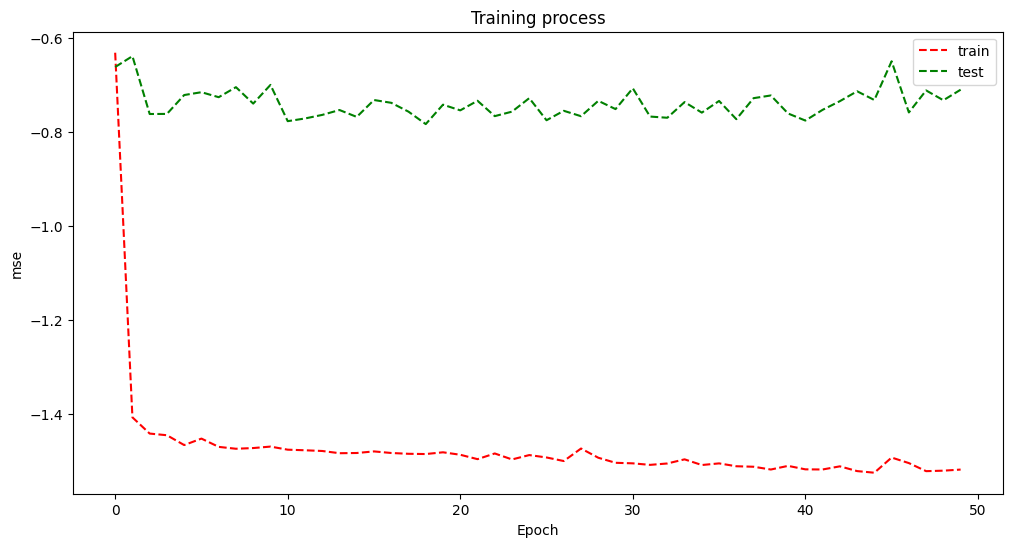

Weather predictions


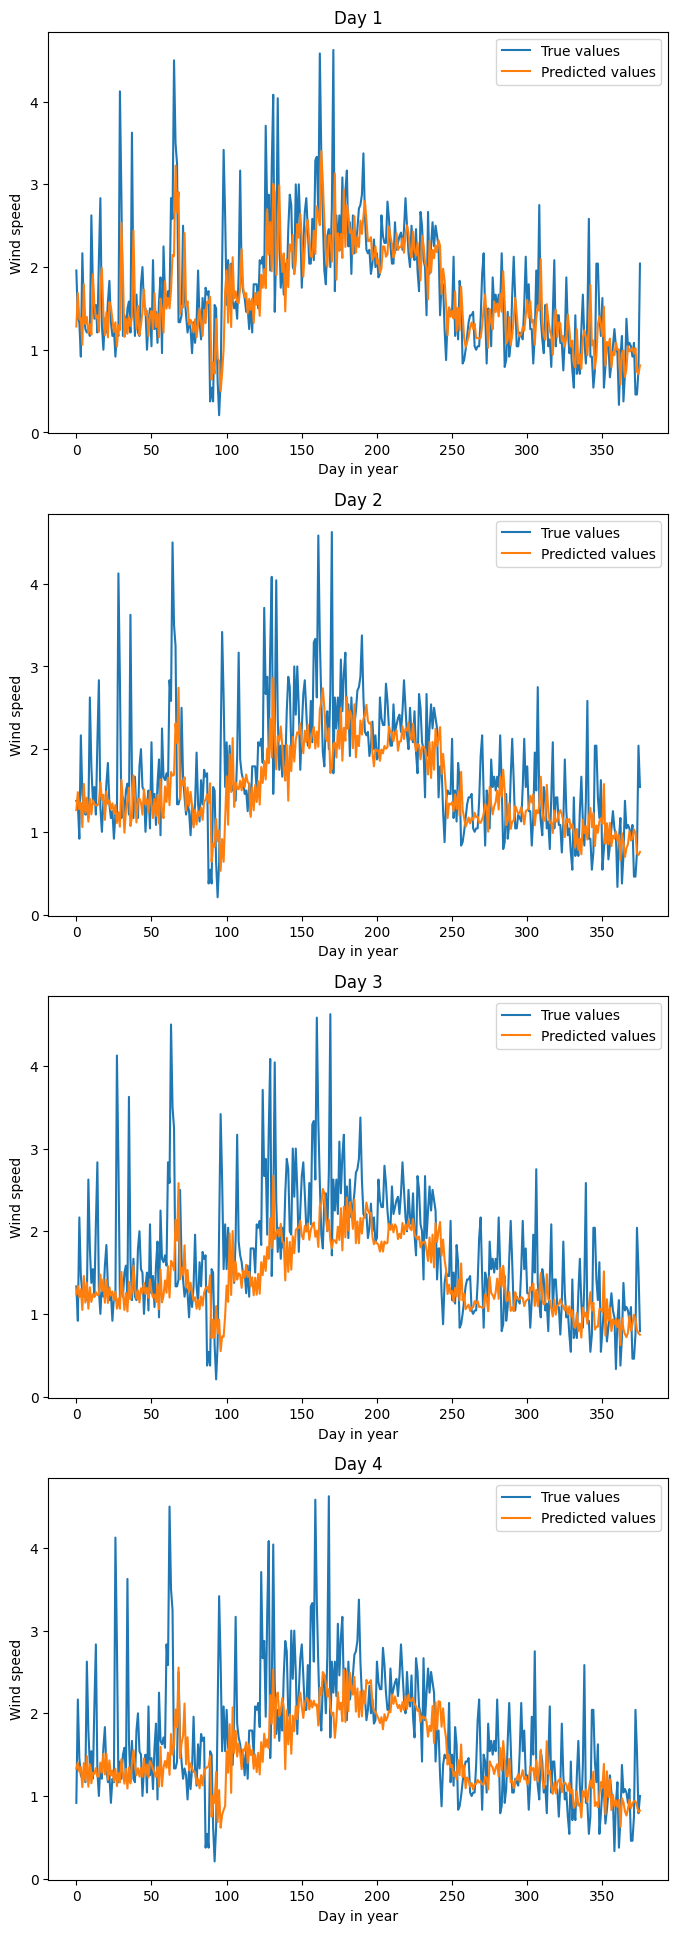

Metrics for 4 consecutive days
Day 1: RMSE=0.5757, MSE=0.3314, MAE=0.4019, R^2=0.4050, Pearson=0.6552, IA=0.7823
Day 2: RMSE=0.6635, MSE=0.4403, MAE=0.4580, R^2=0.2095, Pearson=0.5499, IA=0.6763
Day 3: RMSE=0.6901, MSE=0.4762, MAE=0.4791, R^2=0.1481, Pearson=0.5560, IA=0.6448
Day 4: RMSE=0.6676, MSE=0.4457, MAE=0.4625, R^2=0.2041, Pearson=0.5532, IA=0.6642


In [15]:
y_wLA_pred = model_wLA.predict(X_wLA_test)
metrics_and_plots(history_wLA,y_wLA_test,y_wLA_pred,y_len, False)

## Wind - Vancouver model predicts LA

12/12 [==============================] - 0s 6ms/step


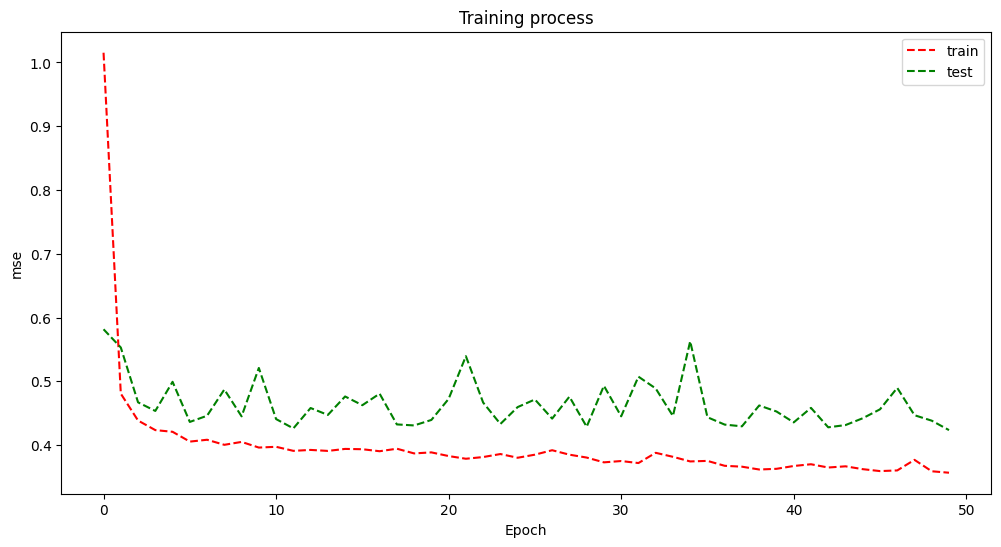

Weather predictions


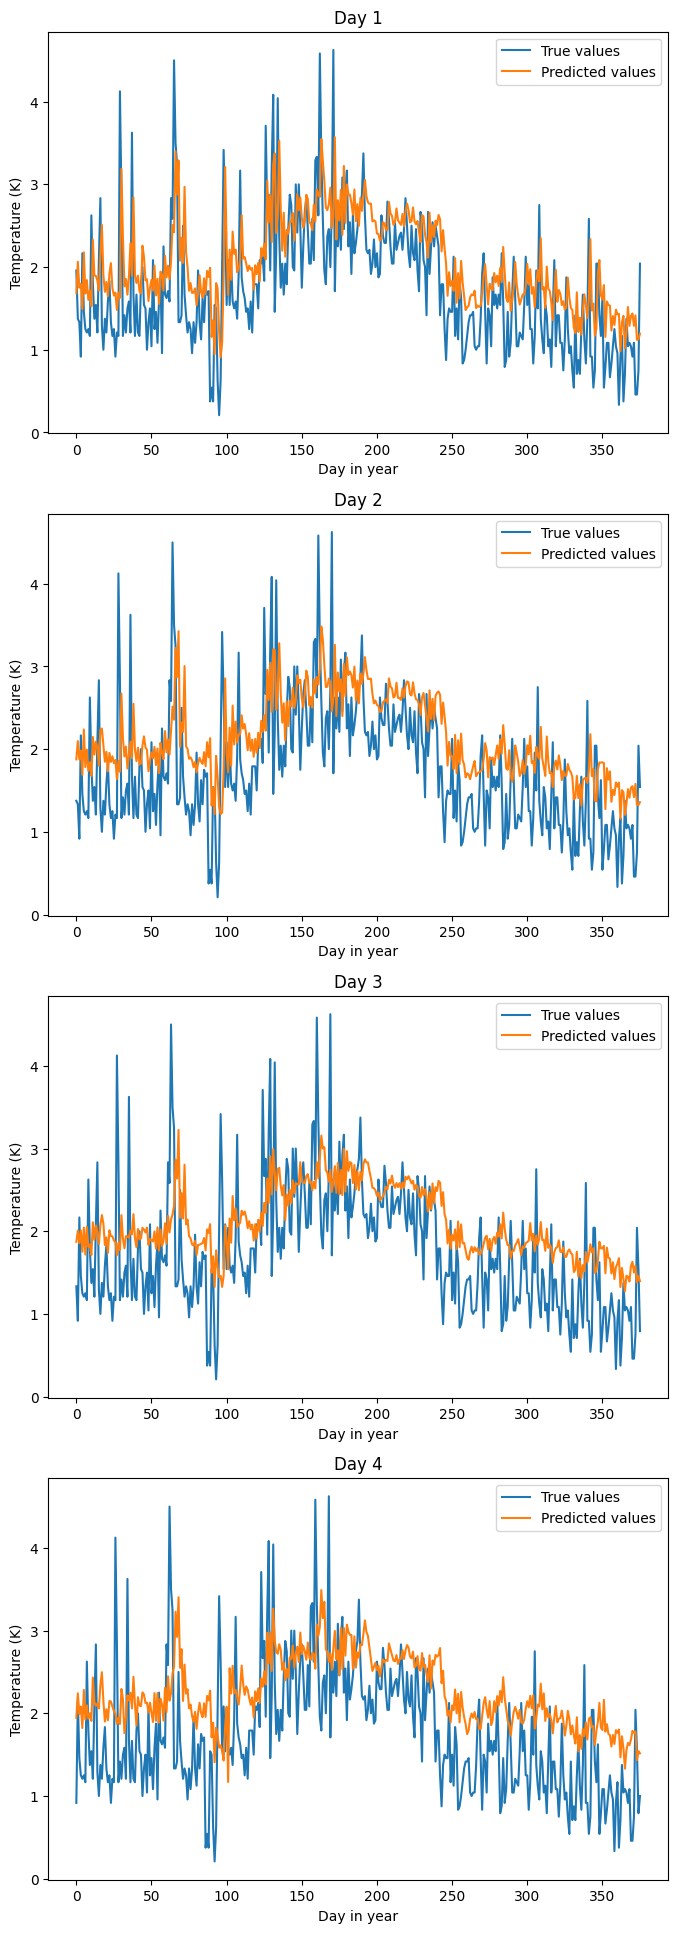

Metrics for 4 consecutive days
Day 1: RMSE=0.6503, MSE=0.4229, MAE=0.5275, R^2=0.2406, Pearson=0.6433, IA=0.7276
Day 2: RMSE=0.7341, MSE=0.5389, MAE=0.6064, R^2=0.0324, Pearson=0.5591, IA=0.6397
Day 3: RMSE=0.7081, MSE=0.5014, MAE=0.5814, R^2=0.1029, Pearson=0.5670, IA=0.6179
Day 4: RMSE=0.8041, MSE=0.6466, MAE=0.6813, R^2=-0.1545, Pearson=0.5318, IA=0.5603


In [17]:
y_wVLA_pred = model_wV.predict(X_wLA_test)
metrics_and_plots(history_wV,y_wLA_test,y_wVLA_pred,y_len)

## Wind - LA model predicts Vancouver

12/12 [==============================] - 0s 2ms/step


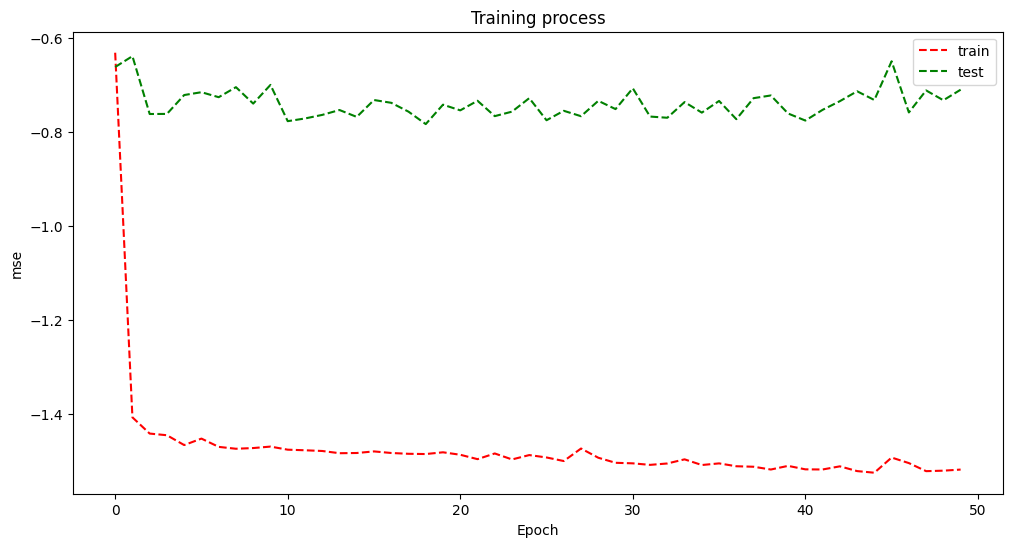

Weather predictions


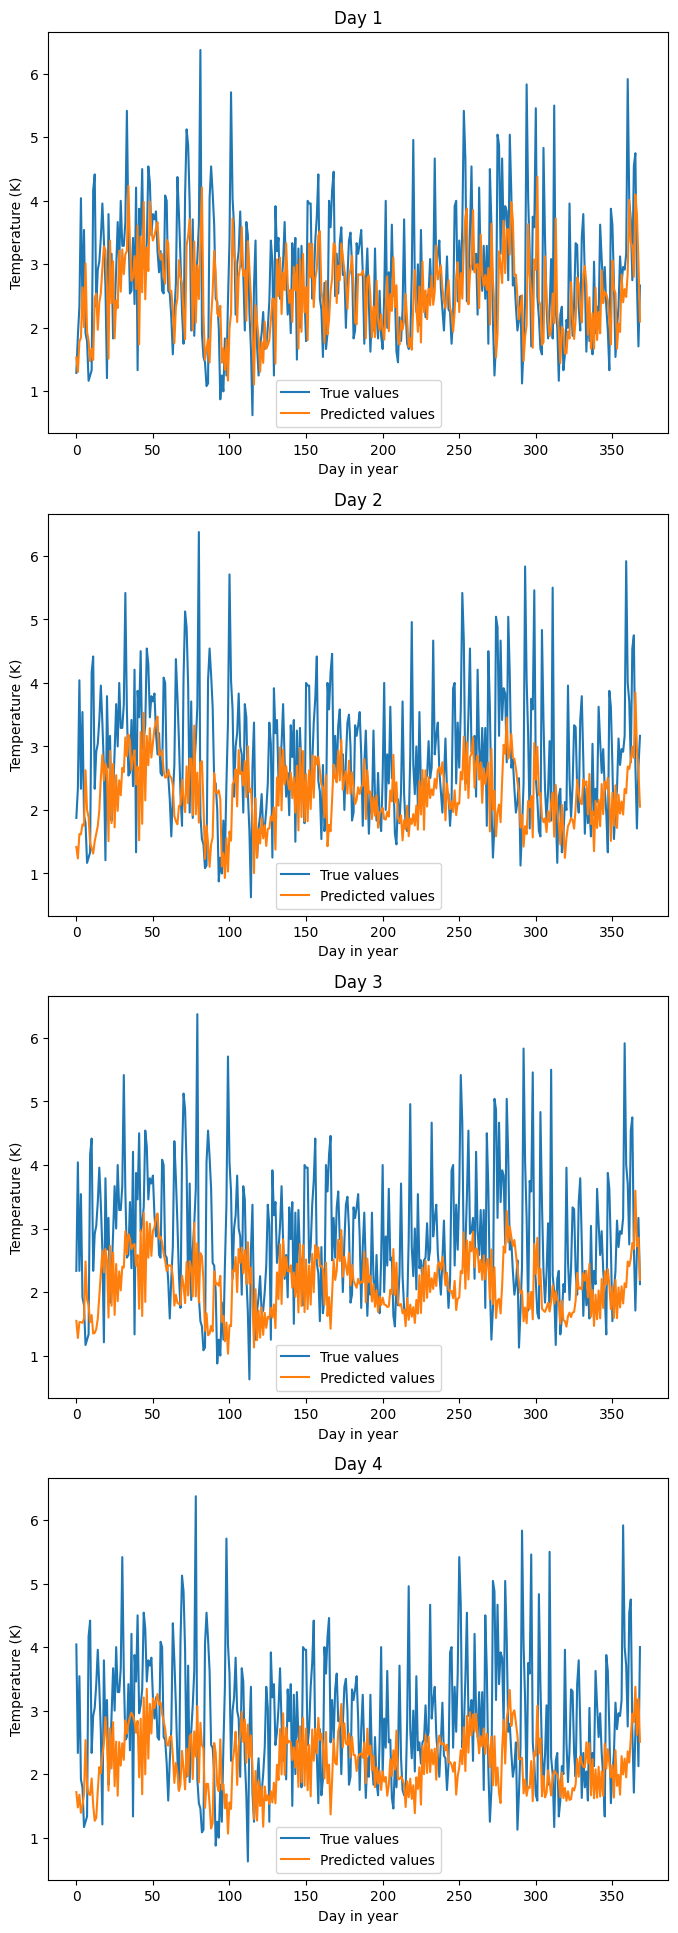

Metrics for 4 consecutive days
Day 1: RMSE=1.0530, MSE=1.1088, MAE=0.7997, R^2=-0.1051, Pearson=0.2956, IA=0.5299
Day 2: RMSE=1.2173, MSE=1.4819, MAE=0.9215, R^2=-0.4863, Pearson=0.1455, IA=0.3888
Day 3: RMSE=1.3088, MSE=1.7129, MAE=0.9873, R^2=-0.7200, Pearson=0.0156, IA=0.3125
Day 4: RMSE=1.2734, MSE=1.6217, MAE=0.9885, R^2=-0.6239, Pearson=0.0237, IA=0.3001


In [18]:
y_wLAV_pred = model_wLA.predict(X_wV_test)
metrics_and_plots(history_wLA,y_wV_test,y_wLAV_pred,y_len)